In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import anndata 

import scanpy as sc
import os
import copy

EPS = 1e-3


In [3]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )



seurat_cluster_type = pd.read_csv('/home/syyang/adipose_arionas/seurat_cluster_label_2.csv')
adipose_sn_ad.obs = adipose_sn_ad.obs.reset_index().merge(seurat_cluster_type, left_on='seurat_clusters', right_on='seurat_clusters', how='left').set_index('index')

adipose_sn_ad.obs.loc[adipose_sn_ad.obs['mapped_cell_type'] == '?', 'mapped_cell_type'] = '0'  # set unknown to 0
adipose_sn_ad.obs['mapped_cell_type'] = adipose_sn_ad.obs['mapped_cell_type'].astype('category') 


adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')
adipose_sn_ad.obs['seurat_clusters'] = adipose_sn_ad.obs['seurat_clusters'].astype('category')

In [4]:
# load human lung disease dataset (scRNAseq)
sc_adata_file = '/home/syyang/GitRepo/cs294/finalproject/UCE_downloads/human_lung_disease.h5ad'
human_lung_disease = sc.read_h5ad(sc_adata_file)

healthy_human_lung = human_lung_disease[human_lung_disease.obs['Disease_Identity'] == 'Control']
# remove multiplets
healthy_human_lung = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] != 'Multiplet'] 
healthy_human_lung.obs['mapped_cell_type'] = healthy_human_lung.obs['CellType_Category']
healthy_human_lung.shape

sc_latent_center = healthy_human_lung.obsm['X_uce'].mean(axis=0)

# Calculate the latent center for each celltype (using scRNAseq data)
celltypes = healthy_human_lung.obs['CellType_Category'].unique()
scRNAseq_celltype_latent_center = {}
scRNAseq_celltype_latent_var = {}
for type in celltypes:
    scRNAseq_celltype_latent_center[type] = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] == type].obsm['X_uce'].mean(axis=0)
    scRNAseq_celltype_latent_var[type] = healthy_human_lung[healthy_human_lung.obs['CellType_Category'] == type].obsm['X_uce'].var(axis=0)
    
sc_latent_center = healthy_human_lung.obsm['X_uce'].mean(axis=0)
sc_latent_center_var = healthy_human_lung.obsm['X_uce'].var(axis=0)

/tmp/ipykernel_330334/1371390375.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  healthy_human_lung.obs['mapped_cell_type'] = healthy_human_lung.obs['CellType_Category']


In [5]:
print(f'cell_type categories:" {adipose_sn_ad.obs["mapped_cell_type"].cat.categories}')

cell_type_center_mean = torch.zeros((adipose_sn_ad.obs['mapped_cell_type'].cat.categories.nunique() , 1280))
for i, type in enumerate(adipose_sn_ad.obs['mapped_cell_type'].cat.categories):
    print(f"i = {i}, type = {type}")
    if type != '0':
        cell_type_center_mean[i] = torch.tensor(scRNAseq_celltype_latent_center[type])
    
    else:
        cell_type_center_mean[i] = torch.tensor(sc_latent_center)
        
        
cell_type_center_var = torch.zeros((adipose_sn_ad.obs['mapped_cell_type'].cat.categories.nunique() , 1280))
for i, type in enumerate(adipose_sn_ad.obs['mapped_cell_type'].cat.categories):
    if type != '0':
        cell_type_center_var[i] = torch.tensor(scRNAseq_celltype_latent_var[type])
    
    else:
        cell_type_center_var[i] = torch.tensor(sc_latent_center_var)

cell_type categories:" Index(['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal'], dtype='object')
i = 0, type = 0
i = 1, type = Endothelial
i = 2, type = Epithelial
i = 3, type = Lymphoid
i = 4, type = Myeloid
i = 5, type = Stromal


In [6]:
# Construct anndata with center UCE latent space for visualization
cell_type_ad = anndata.AnnData(X=adipose_sn_ad[:6, :].X, obs=adipose_sn_ad[:6, ].obs)
cell_type_ad.obs['mapped_cell_type'] = ['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal']
cell_type_ad.obsm['X_uce'] = cell_type_center_mean

In [7]:
simulate_cell_type_centroid = torch.distributions.Normal(cell_type_center_mean,  0.01 * torch.ones_like(cell_type_center_mean) ).sample(torch.Size([200])).view(-1, 1280)

n_samples = simulate_cell_type_centroid.shape[0]

simulated_cell_type_ad = anndata.AnnData(X=adipose_sn_ad[:n_samples, :].X, obs=adipose_sn_ad[:n_samples, ].obs)
simulated_cell_type_ad.obs['mapped_cell_type'] = ['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal'] * int(n_samples / 6)
simulated_cell_type_ad.obsm['X_uce'] = simulate_cell_type_centroid

In [8]:
dd = pd.DataFrame({'cat': adipose_sn_ad.obs['mapped_cell_type'].values, "level": adipose_sn_ad.obs['mapped_cell_type'].cat.codes})
dd.groupby(['level', 'cat']).size().unstack()

cat,0,Endothelial,Epithelial,Lymphoid,Myeloid,Stromal
level,,,,,,
0,45420,0,0,0,0,0
1,0,9440,0,0,0,0
2,0,0,3690,0,0,0
3,0,0,0,1641,0,0
4,0,0,0,0,7418,0
5,0,0,0,0,0,3591


In [9]:
d = pd.DataFrame({"cat":healthy_human_lung.obs['mapped_cell_type'].values, "level": healthy_human_lung.obs['mapped_cell_type'].cat.codes.values})
d.groupby(['level', 'cat']).size().unstack()

cat,Endothelial,Epithelial,Lymphoid,Myeloid,Stromal
level,,,,,
0,2184,0,0,0,0
1,0,4807,0,0,0
2,0,0,13403,0,0
3,0,0,0,73765,0
4,0,0,0,0,1144


In [10]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.n_cat = adata.obs['sample'].nunique()
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        
        self.n_labels = adata.obs['mapped_cell_type'].nunique() #- 1 # -1 because '0' is unknown 
        self.labels = torch.tensor(adata.obs['mapped_cell_type'].cat.codes.values).to(torch.int64)   # cell type labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
# adipose_dataset = scDataset(adipose_sn_ad)
# data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
# a = next(iter(data_loader))
    

In [11]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, total_cell_type, latent_dim=1280, hidden_dim=1280, hidden_layers=1, encode_celltype=False):
        super(Encoder_x, self).__init__()
        
        self.encode_celltype = encode_celltype
        self.laten_dim = latent_dim
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        if encode_celltype:
            self.encoder_cell_type = Encoder_cell_type(input_dim=total_cell_type, latent_dim=latent_dim, hidden_dim=hidden_dim, hidden_layers=1) 
        
        self.linear_mean = nn.Linear(latent_dim, latent_dim * total_cell_type )
        self.linear_var = nn.Linear(latent_dim, latent_dim * total_cell_type )

    def forward(self, x, cell_type_one_hot=None): 
        x = self.layers(x)
        if self.encode_celltype:
            x += self.encoder_cell_type(cell_type_one_hot)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        qz_mean = torch.stack(torch.split(qz_mean, self.laten_dim, dim=-1), dim=1) # shape is of [batch_size x n_cell_type x latent_dim]
        qz_var = torch.stack(torch.split(qz_var, self.laten_dim, dim=-1), dim=1) # shape is of [batch_size x n_cell_type x latent_dim]
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_claffifier(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=30, hidden_layers=1):
        super(Encoder_claffifier, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, output_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        self.softmax = nn.Sequential(nn.Linear(output_dim, output_dim), nn.Softmax(dim=-1))
    def forward(self, x):
        x = self.layers(x)
        prob = self.softmax(x) 
        return prob

class Encoder_cell_type(nn.Module):
    """_summary_
        This encodes the cell type, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=1):
        super(Encoder_cell_type, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        
        self.celltype_zm = nn.Linear(latent_dim, latent_dim)

    def forward(self, cell_type_one_hot):
        zm = self.layers(cell_type_one_hot)
        zm = self.celltype_zm(zm)
        return zm

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=1):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Linear(hidden_dim, output_dim)  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        px_scale = self.px_scale_decoder(x)
        #px_rate = torch.exp(library) * px_scale  # encode library size
        px_rate = library * px_scale  # use observed library size

        
        px_dispersion = self.px_dispersion_decoder(x)
        px_dropout = self.px_dropout_decoder(x)
        
        #px_dispersion = torch.clamp(torch.exp(px_dispersion), min=EPS)  # Clipping at the minimum does not seem to solve the NAN problem in lgammaBACK0
        px_dispersion = torch.exp(px_dispersion)  # positive value
        
        
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Took From `https://github.com/scverse/scvi-tools`  
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    res = mul_case_zero + mul_case_non_zero

    return res



In [28]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, encode_hidden_dim, decode_hidden_dim, total_cat, total_cell_type, alpha = 0.1, encode_celltype=False, device='cpu'):
        """_summary_

        Args:
            input_dim (_type_): _description_
            output_dim (_type_): _description_
            latent_dim (_type_): _description_
            encode_hidden_dim (_type_): _description_
            decode_hidden_dim (_type_): _description_
            total_cat (_type_): _description_
            total_cell_type (_type_): _description_
            alpha (float, optional): _description_. Defaults to 0.1. Penalty for cell-type level center mean on latent space 
            encode_celltype (float, optional): _description_. Encode cell type or not. Defaults to False.
            
        """
        super(snRNAseqVAE, self).__init__()
        
        self.device = device
        self.encode_celltype = encode_celltype 
        self.alpha = torch.tensor(alpha).to(device) # 
        
        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
                
                
        self.encoder_x = Encoder_x(input_dim, total_cell_type, latent_dim, hidden_dim=encode_hidden_dim,  hidden_layers=2, encode_celltype=encode_celltype)
        
        self.encoder_classifier = Encoder_claffifier(input_dim, total_cell_type, hidden_dim=30, hidden_layers=2)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim, hidden_dim=decode_hidden_dim, hidden_layers=1)
    
    def _process_prob(self, prob):
        # Add random noise to avoid multiple values being the same
        noise = torch.rand(prob.shape)
        noise = -torch.log(-torch.log(noise + 1e-8) + 1e-8)
        y = torch.log(prob + 1e-8) + noise.to(self.device) 
        y_hard = (y == torch.max(y, dim=1, keepdim=True)[0]).type(y.dtype)
        y = (y_hard - y).detach() + y
        return y         
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot, l):
        if self.encode_celltype:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)  # [batch_size x n_cell_type x latent_dim]
        else:
            qz_mean, qz_var = self.encoder_x(x)
        
        prob = self.encoder_classifier(x)
        y_hat = self._process_prob(prob)
        
        qz_mean = (torch.matmul(y_hat[:, None, :], qz_mean)).squeeze() # [batch_size x latent_dim]
        qz_var = (torch.matmul(y_hat[:, None, :], qz_var)).squeeze() # [batch_size x latent_dim]
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)

        return y_hat, qz_mean, qz_var, px_rate, px_dispersion, px_dropout 
    
    def get_latent(self, x, cell_type_one_hot=None):
        if self.encode_celltype:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        else:
            qz_mean, qz_var = self.encoder_x(x)
        
        prob = self.encoder_classifier(x)
        y_hat = self._process_prob(prob)
        
        qz_mean = (torch.matmul(y_hat[:, None, :], qz_mean)).squeeze()
        return qz_mean
    
    def forward(self, x, local_l_mean, cat_one_hot, cell_type_one_hot, cell_type_mask, cell_type_center_mean, cell_type_center_var):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]
            cell_type_mask: shape of [batch_size, 1]
            cell_type_center_mean: shape of [n_cell_types, latent_dim]

        Returns:
            _type_: _description_
        """

        
        y_hat, qz_mean, qz_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())


        #kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        kl_z = torch.distributions.kl.kl_divergence(z_dist,  \
            torch.distributions.Normal(  torch.matmul(y_hat, cell_type_center_mean), 20 * torch.matmul(y_hat, cell_type_center_var.sqrt()) ) \
                ).sum(axis=1)
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).sum(axis=-1)
        
        crossentropy = nn.CrossEntropyLoss(reduction='none')
        classifier_loss = (crossentropy(y_hat, cell_type_one_hot) * cell_type_mask.squeeze()).sum()

        return (reconst_loss +  1. * kl_z + classifier_loss).mean()
        #return (reconst_loss + kl_z ).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()

In [29]:
## Training 
def trainning(model, scheduler, train_loader, cell_type_center_mean, cell_type_center_var, device, optimizer, n_epochs=100, mask_rate=0.4, detect_anomaly=False):
    mask_sample = torch.distributions.Bernoulli(torch.tensor([mask_rate]))
    model = model.to(device)
    model.train()
    train_loss = []
    
    cell_type_center_mean = cell_type_center_mean.to(device)
    cell_type_center_var = cell_type_center_var.to(device)
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        N = 0
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            batch_size = x.size(0)
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            
            label_onehot = label_onehot.to(device).float()
            cell_type_mask = mask_sample.sample((batch_size, )).to(device) # size of [batch_size, 1]
            
            local_library_mean = local_library_mean.to(device).view((-1,1))  # size of [batch_size, 1]
            local_library_var = local_library_var.to(device).view((-1,1))  # size of [batch_size, 1]
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, cat_onehot, label_onehot, cell_type_mask, cell_type_center_mean, cell_type_center_var) 
            if detect_anomaly:
                with torch.autograd.detect_anomaly():
                    loss.backward()
            else:
                loss.backward()
            #loss.backward()
            total_loss += loss.item() * x.size(0)
            N += x.size(0)
            optimizer.step()
        scheduler.step(loss)
        print("Epoch: ", epoch, "Loss: ", total_loss/N )
        train_loss.append(total_loss/N)
        
    return train_loss, loss

In [43]:
adipose_sn_ad.obs['mapped_cell_type'].cat.categories

Index(['0', 'Endothelial', 'Epithelial', 'Lymphoid', 'Myeloid', 'Stromal'], dtype='object')

In [44]:
## Data
train_data = adipose_sn_ad[adipose_sn_ad.obs['mapped_cell_type'] != '0', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
#total_cell_type = adipose_dataset.obs['mapped_cell_type'].nunique() - 1 # -1 because '0' is unknown
total_cell_type = adipose_dataset.obs['mapped_cell_type'].nunique() 

cell_type_center_mean = cell_type_center_mean[1:]
cell_type_center_var = cell_type_center_var[1:]

output_dim  = adipose_dataset.data.shape[1]

model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, encode_hidden_dim=1280, decode_hidden_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type, alpha=1., encode_celltype=False, device='cuda')  # Use cell type encoding

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

train_loss, _ = trainning(model, scheduler, data_loader, cell_type_center_mean, cell_type_center_var, device='cuda', optimizer=optimizer, n_epochs=50, mask_rate=1.)

  2%|▏         | 1/50 [00:02<01:50,  2.26s/it]

Epoch:  0 Loss:  6409.921048065967


  4%|▍         | 2/50 [00:04<01:43,  2.15s/it]

Epoch:  1 Loss:  5029.0673873581745


  6%|▌         | 3/50 [00:06<01:37,  2.08s/it]

Epoch:  2 Loss:  4894.479546735599


  8%|▊         | 4/50 [00:08<01:37,  2.11s/it]

Epoch:  3 Loss:  4843.623630236618


 10%|█         | 5/50 [00:10<01:32,  2.05s/it]

Epoch:  4 Loss:  4806.206226665536


 12%|█▏        | 6/50 [00:12<01:30,  2.06s/it]

Epoch:  5 Loss:  4767.170870405838


 14%|█▍        | 7/50 [00:14<01:31,  2.12s/it]

Epoch:  6 Loss:  4741.723375224254


 16%|█▌        | 8/50 [00:16<01:29,  2.12s/it]

Epoch:  7 Loss:  4700.869310330198


 18%|█▊        | 9/50 [00:18<01:24,  2.07s/it]

Epoch:  8 Loss:  4681.8796888637025


 20%|██        | 10/50 [00:20<01:23,  2.08s/it]

Epoch:  9 Loss:  4648.586586016292


 22%|██▏       | 11/50 [00:22<01:20,  2.06s/it]

Epoch:  10 Loss:  4628.8977734526525


 24%|██▍       | 12/50 [00:25<01:18,  2.06s/it]

Epoch:  11 Loss:  4606.028375618212


 26%|██▌       | 13/50 [00:27<01:18,  2.13s/it]

Epoch:  12 Loss:  4587.416886121751


 28%|██▊       | 14/50 [00:29<01:17,  2.16s/it]

Epoch:  13 Loss:  4569.711113644904


 30%|███       | 15/50 [00:31<01:14,  2.13s/it]

Epoch:  14 Loss:  4548.917858517382


 32%|███▏      | 16/50 [00:33<01:13,  2.15s/it]

Epoch:  15 Loss:  4534.636027049796


 34%|███▍      | 17/50 [00:35<01:09,  2.09s/it]

Epoch:  16 Loss:  4517.507855305105


 36%|███▌      | 18/50 [00:37<01:05,  2.04s/it]

Epoch:  17 Loss:  4499.031160601726


 38%|███▊      | 19/50 [00:39<01:02,  2.03s/it]

Epoch:  18 Loss:  4476.523846610745


 40%|████      | 20/50 [00:41<00:59,  1.99s/it]

Epoch:  19 Loss:  4464.520146810149


 42%|████▏     | 21/50 [00:43<00:57,  1.98s/it]

Epoch:  20 Loss:  4441.255890437112


 44%|████▍     | 22/50 [00:45<00:56,  2.02s/it]

Epoch:  21 Loss:  4424.564459943513


 46%|████▌     | 23/50 [00:47<00:53,  2.00s/it]

Epoch:  22 Loss:  4401.313743620903


 48%|████▊     | 24/50 [00:49<00:51,  1.98s/it]

Epoch:  23 Loss:  4387.47119992939


 50%|█████     | 25/50 [00:51<00:50,  2.03s/it]

Epoch:  24 Loss:  4363.675724807869


 52%|█████▏    | 26/50 [00:53<00:48,  2.03s/it]

Epoch:  25 Loss:  4346.814886289942


 54%|█████▍    | 27/50 [00:55<00:46,  2.00s/it]

Epoch:  26 Loss:  4327.133204753867


 56%|█████▌    | 28/50 [00:57<00:44,  2.04s/it]

Epoch:  27 Loss:  4306.871433349799


 58%|█████▊    | 29/50 [00:59<00:42,  2.02s/it]

Epoch:  28 Loss:  4290.097267594792


 60%|██████    | 30/50 [01:01<00:40,  2.03s/it]

Epoch:  29 Loss:  4271.261004510825


 62%|██████▏   | 31/50 [01:03<00:38,  2.04s/it]

Epoch:  30 Loss:  4248.8326344989455


 64%|██████▍   | 32/50 [01:05<00:35,  1.99s/it]

Epoch:  31 Loss:  4226.641610275044


 66%|██████▌   | 33/50 [01:07<00:33,  1.96s/it]

Epoch:  32 Loss:  4210.772661326004


 68%|██████▊   | 34/50 [01:09<00:31,  1.99s/it]

Epoch:  33 Loss:  4190.788382163983


 70%|███████   | 35/50 [01:11<00:29,  1.98s/it]

Epoch:  34 Loss:  4171.29070443567


 72%|███████▏  | 36/50 [01:13<00:27,  1.96s/it]

Epoch:  35 Loss:  4146.370527813469


 74%|███████▍  | 37/50 [01:15<00:25,  1.98s/it]

Epoch:  36 Loss:  4133.099577365872


 76%|███████▌  | 38/50 [01:17<00:23,  1.95s/it]

Epoch:  37 Loss:  4113.659096728932


 78%|███████▊  | 39/50 [01:19<00:21,  1.93s/it]

Epoch:  38 Loss:  4095.525387405147


 80%|████████  | 40/50 [01:21<00:19,  1.96s/it]

Epoch:  39 Loss:  4083.35507933718


 82%|████████▏ | 41/50 [01:23<00:17,  1.94s/it]

Epoch:  40 Loss:  4063.137108352223


 84%|████████▍ | 42/50 [01:25<00:15,  1.92s/it]

Epoch:  41 Loss:  4049.029616398068


 86%|████████▌ | 43/50 [01:27<00:13,  1.95s/it]

Epoch:  42 Loss:  4041.106235075034


 88%|████████▊ | 44/50 [01:29<00:11,  1.95s/it]

Epoch:  43 Loss:  4028.333631895789


 90%|█████████ | 45/50 [01:31<00:09,  1.94s/it]

Epoch:  44 Loss:  4016.746696620139


 92%|█████████▏| 46/50 [01:33<00:08,  2.01s/it]

Epoch:  45 Loss:  4002.4703269703987


 94%|█████████▍| 47/50 [01:35<00:05,  1.99s/it]

Epoch:  46 Loss:  3997.1015282180347


 96%|█████████▌| 48/50 [01:37<00:03,  1.98s/it]

Epoch:  47 Loss:  3991.2393449379365


 98%|█████████▊| 49/50 [01:39<00:02,  2.02s/it]

Epoch:  48 Loss:  3986.3899475050307


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]

Epoch:  49 Loss:  3980.419265214374


In [31]:
#torch.save(model, '/home/syyang/GitRepo/yyyyvae/script/model_44epo_20240430.pth')
#model = torch.load('/home/syyang/GitRepo/yyyyvae/script/model_44epo_20240430.pth')
#_, loss = trainning(model, scheduler, data_loader, cell_type_center_mean, cell_type_center_var, device='cuda', optimizer=optimizer, n_epochs=20, mask_rate=1., detect_anomaly=True)

In [45]:
# Get latent representation of the data
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        #label_onehot = label_onehot.to('cuda').float() * 0  # mask label_onehot
        label_onehot = label_onehot.to('cuda').float()
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        qz_mean= model.get_latent(x)  # with cell type encoding
        #qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [46]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')
sc.tl.umap(train_data_2)


train_data_2.obsm['syy_VAE'].shape

(25780, 1280)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


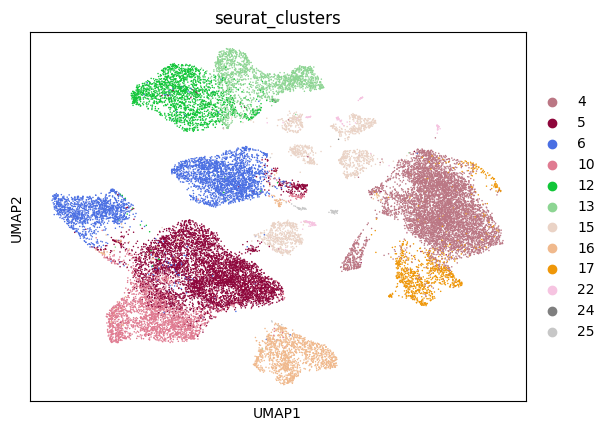

In [47]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


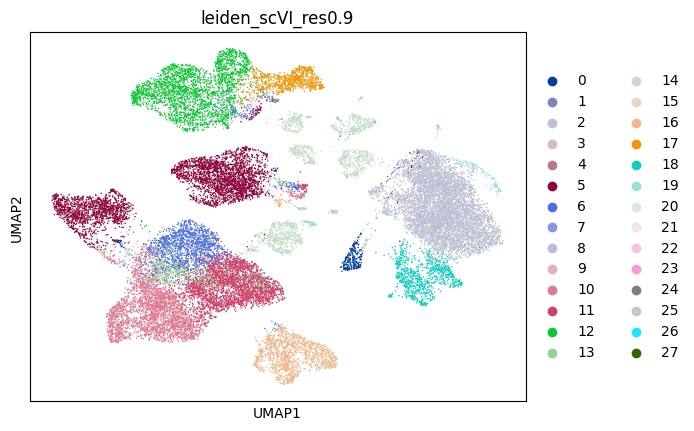

In [48]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


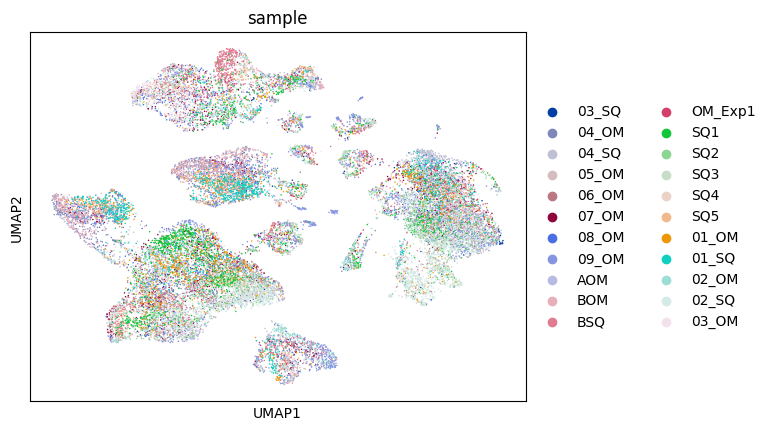

In [49]:
sc.pl.umap(train_data_2, color=['sample'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


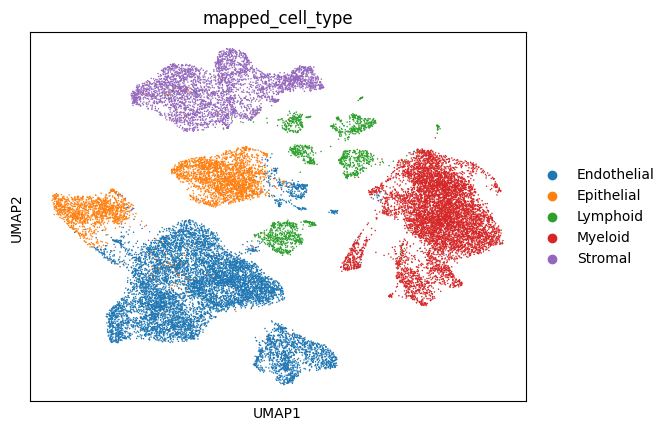

In [50]:
sc.pl.umap(train_data_2, color=['mapped_cell_type'] )

## concatenate scRNAseq & snRNAseq 

In [51]:
concat_ad = anndata.concat([train_data_2, healthy_human_lung, simulated_cell_type_ad], label="dataset", keys=["snRNAseq", "scRNAseq", "celltype_center"])
concat_ad.obsm['syy_VAE'] = np.concatenate((train_data_2.obsm['syy_VAE'], healthy_human_lung.obsm['X_uce'], simulated_cell_type_ad.obsm['X_uce']), axis=0)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [52]:
sc.pp.neighbors(concat_ad, use_rep='syy_VAE')
sc.tl.umap(concat_ad)


/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


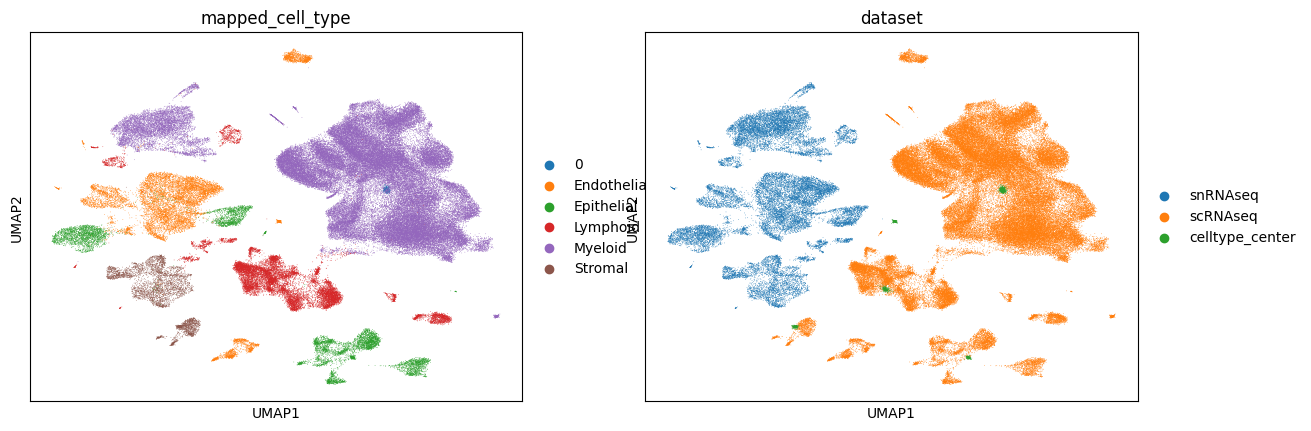

In [53]:
sc.pl.umap(concat_ad, color=['mapped_cell_type', 'dataset'] )

In [54]:
healthy_human_lung.obsm['X_uce'].min(axis=0), healthy_human_lung.obsm['X_uce'].max(axis=0)

(array([-0.10440952, -0.09936623, -0.06736035, ..., -0.10066272,
        -0.04801935, -0.07755798], dtype=float32),
 array([0.04490222, 0.03954226, 0.08342213, ..., 0.05921483, 0.06955586,
        0.08280513], dtype=float32))

In [55]:
train_data_2.obsm['syy_VAE'].min(axis=0), train_data_2.obsm['syy_VAE'].max(axis=0)

(array([-0.15271574, -0.2620739 , -0.14285494, ..., -0.21924993,
        -0.06505515, -0.12266269], dtype=float32),
 array([0.07085003, 0.1127539 , 0.06957453, ..., 0.21266425, 0.11833279,
        0.18857662], dtype=float32))

In [56]:
simulated_cell_type_ad.obsm['X_uce'].min(axis=0), simulated_cell_type_ad.obsm['X_uce'].max(axis=0)

(torch.return_types.min(
 values=tensor([-0.0895, -0.0753, -0.0351,  ..., -0.0593, -0.0314, -0.0608]),
 indices=tensor([ 190, 1007,  787,  ...,  699,  220,  779])),
 torch.return_types.max(
 values=tensor([ 0.0071, -0.0010,  0.0525,  ...,  0.0326,  0.0497,  0.0564]),
 indices=tensor([950, 303, 328,  ..., 884, 111, 411])))

## SCVI's results as reference

In [60]:
adipose_sn_ad.obs

,sample,_scvi_batch,_scvi_labels,leiden_scVI,_scvi_raw_norm_scaling,leiden_scVI_res0.6,leiden_scVI_res0.7,leiden_scVI_res0.8,leiden_scVI_res0.9,seurat_clusters,n_genes,cell_type,mapped_cell_type
index,,,,,,,,,,,,,
TATTTCGGTTCGGTTA-1_03_SQ,03_SQ,0,0,14,0.267352,14,16,15,18,17,3924,Monocytes/Leukocytes,Myeloid
AAAGTCCCAGTGGTGA-1_03_SQ,03_SQ,0,0,14,0.340206,14,16,15,18,17,3839,Monocytes/Leukocytes,Myeloid
TCCTGCAGTTTGGCTA-1_03_SQ,03_SQ,0,0,0,0.358833,0,0,0,0,0,3292,Mature Adipocytes,0
TTTGATCTCTCCTGCA-1_03_SQ,03_SQ,0,0,14,0.380464,14,16,15,18,4,4086,Macrophages,Myeloid
CTACCCATCATCAGTG-1_03_SQ,03_SQ,0,0,0,0.394249,0,0,0,0,0,3551,Mature Adipocytes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CACGAATAGCCTTTGA-1_03_OM,03_OM,21,0,2,22.140675,3,3,2,2,4,82,Macrophages,Myeloid
AGGTGTTTCATACAGC-1_03_OM,03_OM,21,0,9,33.678768,8,8,9,9,8,52,PRM1+,0
TGATTCTCAATCTAGC-1_03_OM,03_OM,21,0,9,34.405651,8,8,9,9,8,58,PRM1+,0


In [57]:
sc.pp.neighbors(adipose_sn_ad, use_rep='X_scVI')
sc.tl.umap(adipose_sn_ad)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


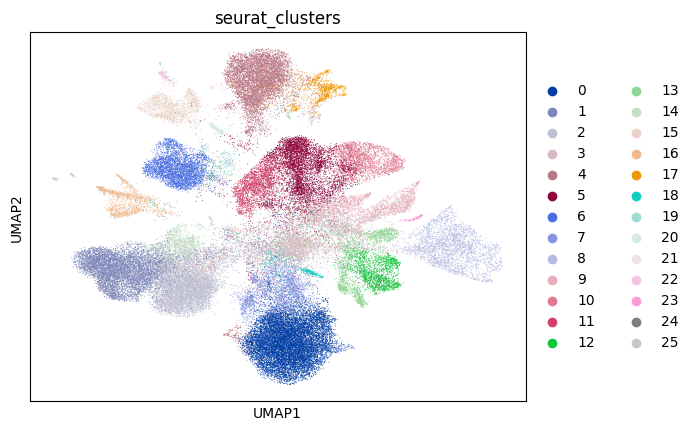

In [68]:

sc.pl.umap(adipose_sn_ad, color=[ 'seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


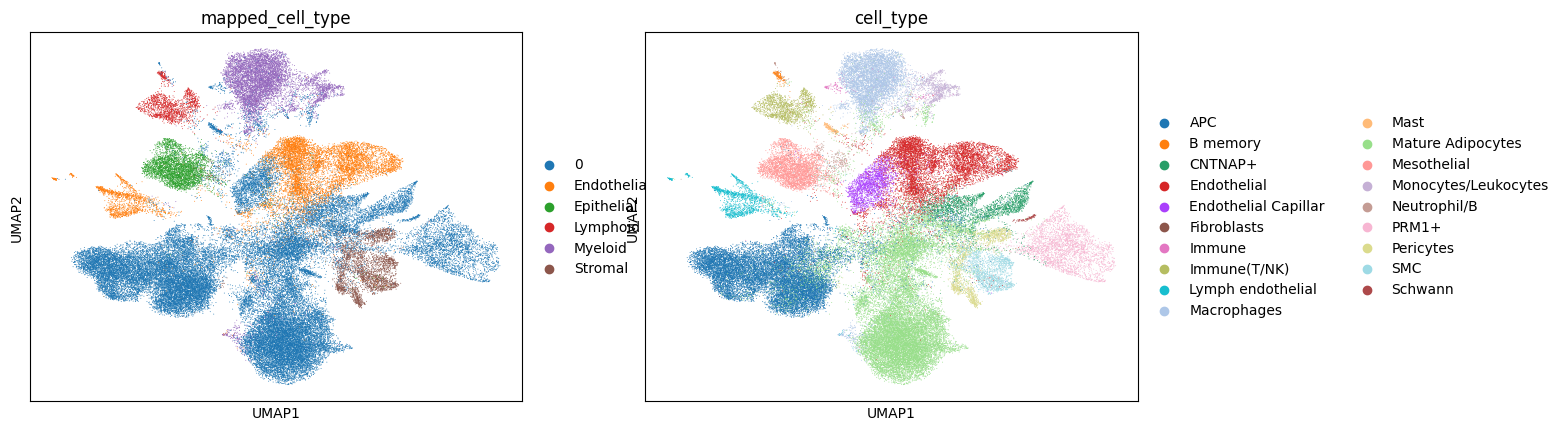

In [67]:
sc.pl.umap(adipose_sn_ad, color=[ 'mapped_cell_type', 'cell_type'] )

In [62]:
sc.pp.neighbors(healthy_human_lung, use_rep='X_uce')
sc.tl.umap(healthy_human_lung)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


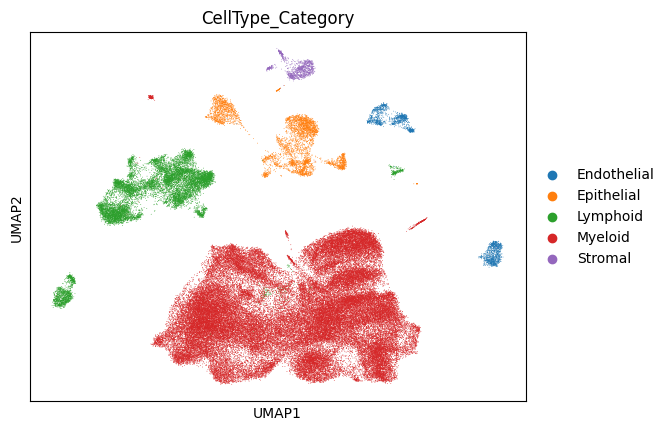

In [66]:

sc.pl.umap(healthy_human_lung, color=['CellType_Category'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


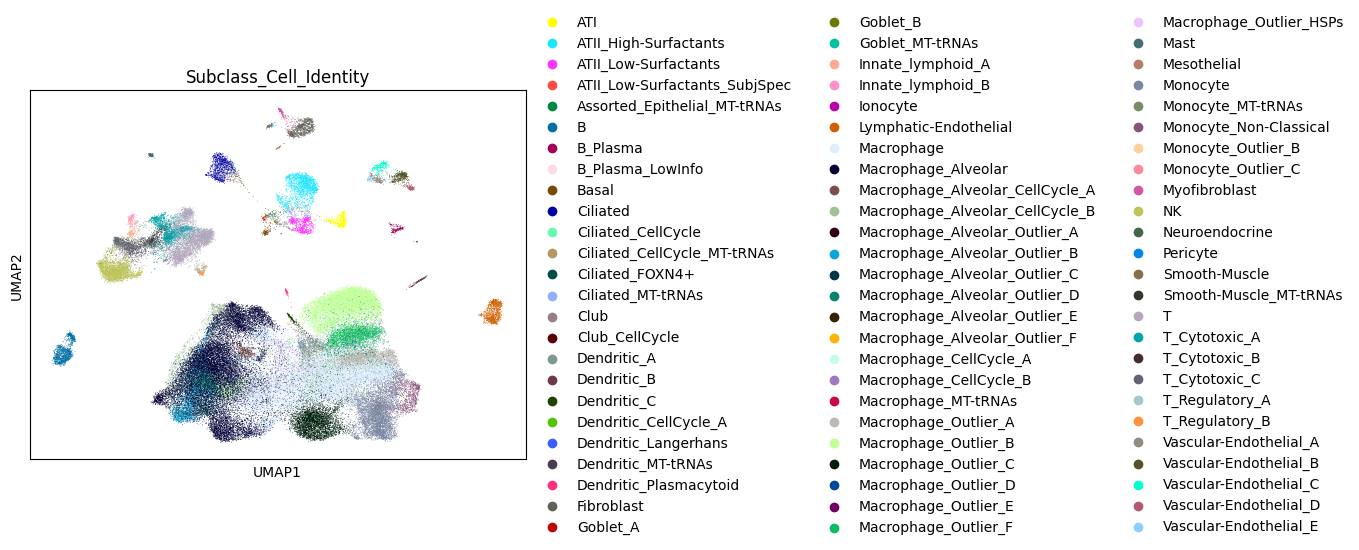

In [65]:
sc.pl.umap(healthy_human_lung, color=['Subclass_Cell_Identity'] )